# **FS25 NLP Project 1: Word Embeddings/Recurrent Neural Networks**

Fabian Dubach

# **Introduction**

The task for this project was to answer common sense questions with the usage of two different architectures: Word embeddings (word2vec, GloVe or fastText) with a classifier and a 2-layer RNN architecture with a classifier (LSTM or GRU). We had to also track the trainings with Wandb (workspace URL: https://wandb.ai/fabian-dubach-hochschule-luzern/CommonsenseQA/workspace?nw=nwuserfabiandubach).

# **Setup**

Import all libraries needed to run the code.

In [1]:
import os
import time
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim

from datasets import load_dataset
from huggingface_hub import hf_hub_download

from tqdm import tqdm, trange
import wandb

c:\Users\fabia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup random seed to ensure reproducibility.

_Info about the seed value: The field of natural language processing began in the 1940s, after World War II. At this time, people recognized the importance of translation from one language to another and hoped to create a machine that could do this sort of translation automatically._

In [2]:
SEED = 1940 # normal: 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Download tokenizer files.

In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\fabia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Load pre-trained FastText word embeddings (300 dimensions)

I first wanted to choose GloVe, because I've seen that GloVe performs very good on semantic similarity and analogical reasoning. Due to the fact that GloVe can only handle uncased embeddings (lowercase), I chose to use FastText. I used 300 dimensions, because it represents word meanings more completely than smaller options (50- or 100 dimensions) while still being practical to use.

In [4]:
model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors", filename="model.bin")

In [5]:
fasttext_model = gensim.models.fasttext.load_facebook_model(model_path)
wv = fasttext_model.wv

Look at vector- and vocab size from the loaded embedding.

In [6]:
print("Vector size:", wv.vector_size)
print("Vocab size:", len(wv.index_to_key))

Vector size: 300
Vocab size: 2000000


Check if known and unknown words create vectors.

In [7]:
print(wv["Hello"])
print(wv["jwadAJKJDwljlkdajl"])

[ 0.18165089  0.11567269  0.0433396   0.07706802  0.05069138  0.03688334
  0.07828845  0.04980808 -0.00644083  0.01029488 -0.04722646 -0.00791209
 -0.11451723  0.03025086  0.09307548  0.01062883 -0.07683911 -0.10517459
  0.00246387  0.07702646  0.04039837  0.01229953 -0.11466632  0.05460778
  0.08104917  0.0413662   0.01208615  0.08066231 -0.10937778  0.0893073
 -0.03935073 -0.03060348 -0.08027591  0.08209406 -0.03217232 -0.03641732
  0.01242283  0.05759722 -0.05894108  0.02777894 -0.18341364 -0.05084793
  0.02241275  0.00440608  0.07912826  0.04474901 -0.03937861 -0.0721626
  0.05589562  0.02635202  0.01346619  0.0173357   0.12057565 -0.019653
 -0.01023086 -0.00223926  0.03043848  0.00747647  0.04588774  0.06308782
 -0.1178913   0.10388953 -0.03564711  0.12567218  0.1470628   0.06018791
 -0.0574099   0.01620604  0.12471652  0.04412995  0.10071367 -0.02047683
 -0.13367647 -0.07360457 -0.13447621 -0.03744629 -0.0009886   0.0684141
  0.06370986  0.05818591 -0.04122961 -0.0223539   0.0769

For the project, we had to use the CommonsenseQA dataset, which is a multiple-choice question answering dataset that contains 12'247 different questions and was developed to benchmark machine understanding of everyday knowledge. For each questions there are 5 given answer choices, where only one of them is correct. To be able to answer these questions, "commonsense" is needed. The dataset is available on HuggingFace: https://huggingface.co/datasets/tau/commonsense_qa.

I split the dataset into training, validation and test sets to allow for model development and evaluation. I used the last 1'000 examples from the training set for validation and the original validation set for testing, since the real test set has no answer keys.

In [8]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


Login for the experiment tracking.

In [9]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: fabian-dubach (fabian-dubach-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# **Data Exploration**

In this section I tried to get some insight to understand its structure and patterns.

### 1. Explore dataset structure

In [10]:
print("\033[4m" + "Dataset Features" + "\033[0m")
for feature in train.features:
    print(feature)
print("\n" + "\033[4m" + "Example" + "\033[0m")
for feature in train.features:
    print(feature + ":", train[0][str(feature)])

Dataset Features
id
question
question_concept
choices
answerKey

Example
id: 075e483d21c29a511267ef62bedc0461
question: The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?
question_concept: punishing
choices: {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}
answerKey: A


### 2. Get a general info about each dataset

In [11]:
def dataset_to_df(dataset):
    return pd.DataFrame(dataset)

train_df = dataset_to_df(train)
valid_df = dataset_to_df(valid)
test_df = dataset_to_df(test)

In [12]:
print("\033[4m" + "Train Info" + "\033[0m")
print(train_df.info())

Train Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8741 entries, 0 to 8740
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                8741 non-null   object
 1   question          8741 non-null   object
 2   question_concept  8741 non-null   object
 3   choices           8741 non-null   object
 4   answerKey         8741 non-null   object
dtypes: object(5)
memory usage: 341.6+ KB
None


In [13]:
print("\033[4m" + "Validation Info" + "\033[0m")
print(valid_df.info())

Validation Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1000 non-null   object
 1   question          1000 non-null   object
 2   question_concept  1000 non-null   object
 3   choices           1000 non-null   object
 4   answerKey         1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB
None


In [14]:
print("\033[4m" + "Test Info" + "\033[0m")
print(test_df.info())

Test Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                1221 non-null   object
 1   question          1221 non-null   object
 2   question_concept  1221 non-null   object
 3   choices           1221 non-null   object
 4   answerKey         1221 non-null   object
dtypes: object(5)
memory usage: 47.8+ KB
None


### 3. Analyze question lengths

In [15]:
combined_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)

combined_df['question_length'] = combined_df['question'].apply(len)
combined_df['question_word_count'] = combined_df['question'].apply(lambda x: len(x.split()))

print("\033[4m" + "Question length (characters)" + "\033[0m")
print(f"Min: {combined_df['question_length'].min()}")
print(f"Max: {combined_df['question_length'].max()}")
print(f"Mean: {combined_df['question_length'].mean():.2f}")
print(f"Median: {combined_df['question_length'].median()}")

print("\n\033[4m" + "Question Word Count" + "\033[0m")
print(f"Min: {combined_df['question_word_count'].min()}")
print(f"Max: {combined_df['question_word_count'].max()}")
print(f"Mean: {combined_df['question_word_count'].mean():.2f}")
print(f"Median: {combined_df['question_word_count'].median()}")

Question length (characters)
Min: 15
Max: 376
Mean: 69.31
Median: 64.0

Question Word Count
Min: 3
Max: 63
Mean: 13.23
Median: 12.0


### 4. Analyze option lengths

In [16]:
def get_option_lengths(choices):
    return [len(text) for text in choices['text']]

def get_option_word_counts(choices):
    return [len(text.split()) for text in choices['text']]

combined_df['option_lengths'] = combined_df['choices'].apply(get_option_lengths)
combined_df['option_word_counts'] = combined_df['choices'].apply(get_option_word_counts)

# Flatten the lists for analysis
all_option_lengths = [length for lengths in combined_df['option_lengths'] for length in lengths]
all_option_word_counts = [count for counts in combined_df['option_word_counts'] for count in counts]

print("\033[4m" + "Option length (characters)" + "\033[0m")
print(f"Min: {min(all_option_lengths)}")
print(f"Max: {max(all_option_lengths)}")
print(f"Mean: {np.mean(all_option_lengths):.2f}")
print(f"Median: {np.median(all_option_lengths)}")

print("\033[4m" + "\nOption word count" + "\033[0m")
print(f"Min: {min(all_option_word_counts)}")
print(f"Max: {max(all_option_word_counts)}")
print(f"Mean: {np.mean(all_option_word_counts):.2f}")
print(f"Median: {np.median(all_option_word_counts)}")

Option length (characters)
Min: 3
Max: 149
Mean: 9.34
Median: 9.0

Option word count
Min: 1
Max: 26
Mean: 1.52
Median: 1.0


### 5. Analyze answer distribution

In [17]:
def extract_answer_letter(example):
    return example['answerKey']

combined_df['answer_letter'] = combined_df.apply(extract_answer_letter, axis=1)

print("\033[4m" + "Answer Distribution" + "\033[0m")
print(combined_df['answer_letter'].value_counts(), "\n")
print(combined_df['answer_letter'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

Answer Distribution
answer_letter
D    2236
B    2228
C    2187
E    2163
A    2148
Name: count, dtype: int64 

answer_letter
D     20.4%
B    20.32%
C    19.95%
E    19.73%
A    19.59%
Name: proportion, dtype: object


### 6. Extract common question words/phrases

In [18]:
def get_common_words(text_series, top_n=20):
    stop_words = set(stopwords.words('english'))
    all_words = []
    
    for text in text_series:
        words = word_tokenize(text.lower())
        filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
        all_words.extend(filtered_words)
    
    return Counter(all_words).most_common(top_n)

print("\033[4m" + "Common Words in Questions" + "\033[0m")
common_words = get_common_words(train_df['question'], 10)
for word, count in common_words:
    print(f"{word}: {count}")

Common Words in Questions
would: 1101
people: 694
might: 669
likely: 637
someone: 556
find: 509
could: 502
person: 498
get: 372
one: 367


### 7. Visualize question length distribution

Text(0, 0.5, 'Frequency')

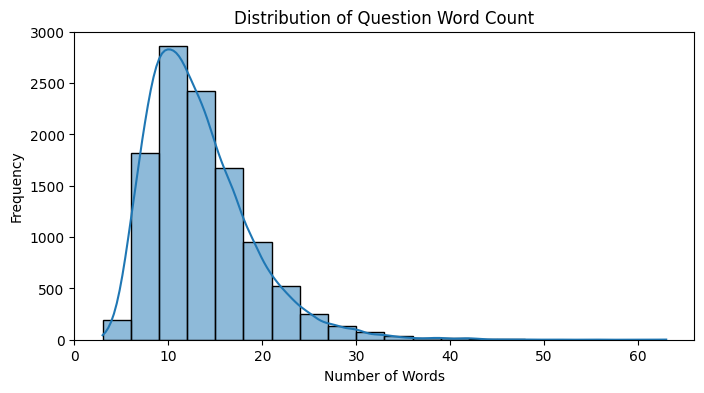

In [19]:
plt.figure(figsize=(8, 4))
sns.histplot(combined_df['question_word_count'], bins=20, kde=True)
plt.title('Distribution of Question Word Count')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

### 8. Visualize answer distribution

Text(0, 0.5, 'Count')

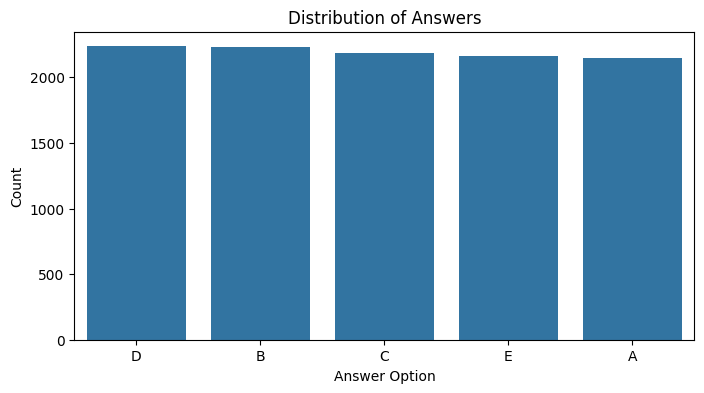

In [20]:
plt.figure(figsize=(8, 4))
sns.countplot(x='answer_letter', data=combined_df, order=combined_df['answer_letter'].value_counts().index)
plt.title('Distribution of Answers')
plt.xlabel('Answer Option')
plt.ylabel('Count')

# **Preprocessing**

For the preprocessing I looked at the following points:

1. Tokenization
2. Lowercasing, stemming, lemmatizing, stopword/punctuation removal 
3. Removal of unknown/other words 
4. Format cleaning (e.g. html-extracted text) 
5. Truncation 
6. Feature selection 

Here are my decisions and justifications for using or not using the above listed preprocessing methods:

1. Tokenization is absolutely mandatory.
2. I chose not to use lowercasing to keep the semantic meaning of the words. Stemming and lemmatizing are not needed, because FastText already captures semantic similarities. Stopword/Punctuation removal is generally not a needed for a RNN due to the fact that the model can then learn to ignore irrelevant words by itself.
3. Removal of unknown/other words is also not needed, because FastText can handle them.
4. Format cleaning is not needed, because the CommonsenseQA dataset doesn't include any markup text.
5. Due to the fact that the longest question is 376 characters long, truncation is not needed.
6. Feature selection is also not needed. RNNs typically work with the full sequence rather than selected features.

In [21]:
def preprocessing(text):
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

The `get_embedding()` function transforms any text sentence into a fixed-length vector representation by averaging the word embeddings of each token in the sentence. If no tokens were found, a zero vector is being returned.

In [ ]:
def get_embedding(sentence):
    tokens = preprocessing(sentence)
    word_vectors = []
    for token in tokens:
        try:
            word_vectors.append(fasttext_model.wv[token])
        except KeyError:
            continue
    
    # Return the mean of the word vectors
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(fasttext_model.vector_size)  # Return a zero vector if no tokens were found

For the model to interpret the answers correctly, I converted the answer keys into numerical indices (0, 1, 2, 3, 4).

In [23]:
def answer_key_to_index(answer_key):
  return ord(answer_key) - ord("A")

The `compute_embeddings()` function creates embeddings for every text data (questions and choices).

In [24]:
def compute_embeddings(example):
    question_embeddings = get_embedding(example["question"])
    choice_embeddings = [get_embedding(choice) for choice in example["choices"]["text"]]
    
    example["question_emb"] = question_embeddings.tolist()
    example["choice_embs"] = [embedding.tolist() for embedding in choice_embeddings]
    return example

train = train.map(compute_embeddings)
valid = valid.map(compute_embeddings)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 1032.72 examples/s]


### **Word Embedding**

Implement a class which can convert a regular dataset into a PyTorch-compatible dataset.

In [25]:
class CommonsenseQADataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question_tensor = torch.tensor(example["question_emb"]).float()
        choices_tensor = torch.tensor(example["choice_embs"]).float()
        answer_index = answer_key_to_index(example["answerKey"])
        return question_tensor, choices_tensor, torch.tensor(answer_index).long()

### **RNN**

Implement class that creates a PyTorch-compatible dataset for processing question-answering pairs through an RNN model. It tokenizes text, combines each question with each possible answer (separated by a special token), converts tokens to embedding vectors and returns these sequences along with their lengths and the correct answer index.

In [26]:
class CommonsenseRNNDataset(Dataset):
    def __init__(self, hf_dataset, word_vectors, embedding_dim=300):
        self.data = hf_dataset
        self.wv = word_vectors
        self.embedding_dim = embedding_dim
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data[idx]
        
        # Get question and choices
        question = example["question"]
        choices = example["choices"]["text"]
        
        # Process question
        question_emb = get_embedding(question)
        
        # Process choices
        choice_embs = [get_embedding(choice) for choice in choices]
        choice_tensor = torch.tensor(np.array(choice_embs), dtype=torch.float32)
        
        # Get answer index
        answer_idx = answer_key_to_index(example["answerKey"])
        
        return torch.tensor(question_emb, dtype=torch.float32), choice_tensor, torch.tensor(answer_idx)

This function prepares batches of sequence data for efficient RNN processing.

1. Collect and flatten all sequences, lengths and answers from the batch
2. Sort sequences by length in descending order (optimizing RNN computation)
3. Pad shorter sequences to match the longest one
4. Create a mapping index to help reconstruct the original batch organization
5. Return the padded sequences, their sorted lengths, reconstruction indices and answer labels

The sorting step is important for using packed sequences in RNNs, which improves efficiency by processing only valid parts of each sequence, while the indices allow the model to match processed sequences back to their original question-answer pairs.

In [ ]:
def rnn_collate_fn(batch):
    questions, choices, labels = zip(*batch)
    
    question_tensors = [torch.tensor(q, dtype=torch.float32) for q in questions]
    choice_tensors = [[torch.tensor(c, dtype=torch.float32) for c in cs] for cs in choices]
    label_tensors = torch.tensor(labels, dtype=torch.long)
    
    padded_questions = pad_sequence(question_tensors, batch_first=True)
    question_lengths = torch.tensor([len(q) for q in question_tensors])
    
    all_choices = []
    choice_lengths = []
    for choice_set in choice_tensors:
        all_choices.extend(choice_set)
        choice_lengths.extend([len(c) for c in choice_set])
    
    padded_choices = pad_sequence(all_choices, batch_first=True)
    choice_lengths = torch.tensor(choice_lengths)

    batch_size = len(batch)
    num_choices = len(choice_tensors[0])
    indices = torch.zeros(batch_size, num_choices, dtype=torch.long)
    
    current_idx = 0
    for i in range(batch_size):
        for j in range(num_choices):
            indices[i, j] = current_idx
            current_idx += 1
    
    return padded_questions, question_lengths, padded_choices, choice_lengths, indices, label_tensors

# **Model**

### Word embeddings

This `WordEmbeddingQAClassifier()` is a neural network model for multiple-choice question answering using pre-computed word embeddings.

1. Take already-embedded question and choice vectors as input
2. Expand the question embedding to pair with each answer choice
3. Concatenate each question-choice pair along the feature dimension
4. Processe these concatenated vectors through a simple feed-forward network:
    - A hidden layer with ReLU activation and dropout for regularization
    - An output layer that produces a single score for each question-choice pair



The model essentially measures compatibility between questions and potential answers, with higher scores indicating better matches. During training, these scores are compared against the correct answer to tune the model's parameters.

In [ ]:
class WordEmbeddingQAClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, dropout_rate):
        super(WordEmbeddingQAClassifier, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, question, choices):
        question_expanded = question.unsqueeze(1).expand(-1, choices.size(1), -1)
        
        combined = torch.cat((question_expanded, choices), dim=2)

        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x.squeeze(-1)

### RNN

This `QARNNModel()` class implements a neural network for question answering using an LSTM (Long Short-Term Memory) network. The reason why I chose the LSTM network is, that I think the LSTM's memory cell structure might better preserve information across the combined question-answer sequences, especially when there are key contextual elements that need to be remembered from earlier parts of the sequence to evaluate answer choices properly.

1. Process sequences of word embeddings through a bidirectional LSTM with 2 layers
2. The LSTM handles variable-length sequences efficiently by using packed sequences
3. After processing through the LSTM, it extracts the final hidden states from both directions (forward and backward) and concatenates them
4. These concatenated hidden states are passed through a classification head (a simple feed-forward network)
5. The classification head outputs a score for each sequence
6. The scores are then rearranged to match each question with its multiple answer choices using the indices parameter

The bidirectional nature of the LSTM allows the model to incorporate context from both before and after each word in the sequence. The model combines the question and each potential answer into a single sequence, processes them through the LSTM, and outputs scores indicating which answer is most likely correct.

In [ ]:
class QARNNModel(nn.Module):
    def __init__(self, embedding_dim=300, hidden_dim=64, num_choices=5, dropout_rate=0.2):
        super(QARNNModel, self).__init__()
        
        self.question_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.choice_encoder = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        self.scoring = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, questions, _, choices, __, indices):
        batch_size = questions.size(0)

        question_encoded = self.question_encoder(questions)
        choice_encoded = self.choice_encoder(choices)
        
        scores = []
        for i in range(batch_size):
            q_encoded = question_encoded[i]
            choice_idxs = indices[i]
            q_choices = []

            for idx in choice_idxs:
                q_choices.append(choice_encoded[idx])
            
            q_choices = torch.stack(q_choices)
            q_expanded = q_encoded.unsqueeze(0).expand(len(choice_idxs), -1)
            combined = torch.cat([q_expanded, q_choices], dim=1)
            
            score = self.scoring(combined).squeeze(-1)
            scores.append(score)
        
        return torch.stack(scores)

# **Training**

 Check if a CUDA-compatible GPU is available and set the device for tensor computations accordingly, otherwise use CPU.

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


This `save_checkpoint()` function saves model checkpoints during training by storing the model's state, optimizer state, current epoch and best validation accuracy to a file path. When saving the best-performing model, it also logs this information to Weights & Biases (wandb) for tracking, with error handling in case the logging fails.

In [ ]:
def save_checkpoint(model, optimizer, epoch, save_path, best_val_accuracy):
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_accuracy': best_val_accuracy
    }
    torch.save(checkpoint, save_path)
    try:
        if 'best_model' in save_path:
            wandb.log({
                "best_model_checkpoint": {
                    "path": save_path,
                    "epoch": epoch,
                    "val_accuracy": best_val_accuracy
                }
            })
    except Exception as e:
        print(f"Error logging checkpoint to wandb: {e}")

### **Word Embedding Training**

Set hyperparameters for the word embedding model.

Embedding Dimension: **300**<br>
Hidden Dimension: **64 - 256**<br>
Dropout Rate: **0.2 - 0.4**<br>
Learning Rate: **1e-4 - 1e-3**<br>
Weight Decay: **1e-6 - 1e-3**<br>
Batch Size: **32 - 2048**<br>
Epochs: **50 - 100**<br>
Gradient Clipping: **0.5 - 2**

The embedding dimension was fixed at 300 to match the pre-trained FastText model. I started with smaller hidden dimensions (64) and gradually increased to 256 to see if larger representation capacity improved performance. Dropout rates were kept moderate (0.2-0.4) to prevent overfitting while preserving enough information flow. Learning rates were maintained in the standard range for NLP tasks (1e-4 to 1e-3), with smaller values for more stability. Weight decay values varied from 1e-6 to 1e-3 to test different regularization strengths. I experimented with a wide range of batch sizes (32 to 2048) to find the optimal trade-off between training speed and generalization. For the epochs I first chose 100, but then saw, that the model started to overfit already before, so I cut them down to 50. I also tried out different gradient clipping values, but I never went under 0.

In [92]:
embedding_dim_word_embedding = 300 # FastText -> 300d
hidden_dim_word_embedding = 128
dropout_rate_word_embedding = 0.2
learning_rate_word_embedding = 1e-4
weight_decay_word_embedding = 1e-3
batch_size_word_embedding = 64
num_epochs_word_embedding = 50
gradient_clip_val_word_embedding = 0.5

Create a PyTorch-compatible dataset for the train and the validation dataset.

In [103]:
train_dataset_word_embedding = CommonsenseQADataset(train)
valid_dataset_word_embedding = CommonsenseQADataset(valid)

Create two PyTorch DataLoader objects to efficiently batch and load data during training.

In [104]:
train_loader = DataLoader(
    train_dataset_word_embedding, 
    batch_size=batch_size_word_embedding, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset_word_embedding, 
    batch_size=batch_size_word_embedding, 
    shuffle=False,  # No need to shuffle validation data
    num_workers=0,
    pin_memory=True
)

Initialize the word embedding model and move it to the appropriate computing device.

In [105]:
word_embedding_model = WordEmbeddingQAClassifier(embedding_dim=embedding_dim_word_embedding, hidden_dim=hidden_dim_word_embedding, dropout_rate=dropout_rate_word_embedding)
word_embedding_model = word_embedding_model.to(device)

print(word_embedding_model)

WordEmbeddingQAClassifier(
  (fc1): Linear(in_features=600, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


Set up the loss function and optimizer for training the word embedding model.

I'm using CrossEntropyLoss as my loss function because it's well-suited for multi-class classification problems. As a optimizer I chose AdamW, because it combines the benefits of Adam with proper weight decay regularization. This helps prevent overfitting while maintaining good convergence properties

In [108]:
criterion_word_embedding = nn.CrossEntropyLoss()
optimizer_word_embedding = torch.optim.AdamW(word_embedding_model.parameters(), lr=learning_rate_word_embedding, weight_decay=weight_decay_word_embedding)

Initializes wandb tracking run for experiment monitoring of the word embedding model training.

In [ ]:
word_embedding_run = wandb.init(
  project="CommonsenseQA",
  name=f"word_embedding-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "word_embedding",
    "embedding_dim": embedding_dim_word_embedding,
    "hidden_dim": hidden_dim_word_embedding,
    "batch_size": batch_size_word_embedding,
    "epoch": num_epochs_word_embedding,
    "dropout_rate": dropout_rate_word_embedding,
    "weight_decay": weight_decay_word_embedding,
  },
  reinit=True,
)

The `train_word_embedding()` function trains a model that uses pre-computed word embeddings for question answering. It handles the complete training cycle including batch processing, optimization, evaluation and model saving. The function implements early stopping to prevent overfitting by monitoring validation accuracy and halting training when no improvement occurs for a specified number of epochs. It uses gradient clipping to stabilize training and logs metrics to Weights & Biases for experiment tracking. Throughout training, it saves checkpoints at regular intervals and maintains the best performing model based on validation accuracy.

In [ ]:
def train_word_embedding(
    model, 
    train_loader, 
    valid_loader, 
    criterion, 
    optimizer, 
    num_epochs, 
    device, 
    checkpoint_dir='checkpoints', 
    gradient_clip_val=1,
    save_interval=1,
    patience=5
):
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Initialize best validation accuracy
    best_word_embedding_accuracy = 0
    start_epoch = 0
    
    # Early stopping variables
    no_improve_count = 0
    early_stop = False
    
    for epoch in (pbar := trange(start_epoch, num_epochs)):
        if early_stop:
            print(f"\nEarly stopping triggered after {epoch} epochs!")
            break
            
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

        model.train()
        train_total_loss = 0.0
        train_correct = 0
        train_total = 0

        for question_batch, choices_batch, y_batch in train_loader:
            optimizer.zero_grad()

            question_batch = question_batch.to(device)
            choices_batch = choices_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            outputs = model(question_batch, choices_batch)

            # Compute loss
            train_batch_loss = criterion(outputs, y_batch)
            train_total_loss += train_batch_loss.item()

            # Compute accuracy
            train_predictions = torch.argmax(outputs, dim=1)
            train_correct += (train_predictions == y_batch).sum().item()
            train_total += y_batch.size(0)

            # Backward pass
            train_batch_loss.backward()

            # Apply gradient clipping before optimizer step
            if gradient_clip_val > 0:
                nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)

            optimizer.step()

        # Calculate train statistics
        avg_train_loss = train_total_loss / len(train_loader)
        train_accuracy = train_correct / train_total

        # Evaluate
        model.eval()
        val_correct = 0
        val_total = 0
        val_total_loss = 0

        with torch.no_grad():
            for question_batch, choices_batch, y_batch in valid_loader:
                question_batch = question_batch.to(device)
                choices_batch = choices_batch.to(device)
                y_batch = y_batch.to(device)

                val_outputs = model(question_batch, choices_batch)

                # Calculate validation loss
                val_batch_loss = criterion(val_outputs, y_batch)
                val_total_loss += val_batch_loss.item()

                val_predictions = torch.argmax(val_outputs, dim=1)
                val_correct += (val_predictions == y_batch).sum().item()
                val_total += y_batch.size(0)

        # Calculate validation statistics
        avg_val_loss = val_total_loss / len(valid_loader)
        val_accuracy = val_correct / val_total
        
        pbar.set_postfix({
            "train_loss": avg_train_loss, 
            "train_acc": train_accuracy, 
            "val_acc": val_accuracy
        })

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy,
            "learning_rate": optimizer.param_groups[0]['lr'],
        })

        # Save checkpoint periodically
        if (epoch + 1) % save_interval == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
            save_checkpoint(model, optimizer, epoch+1, checkpoint_path, best_word_embedding_accuracy)

        # Save best model based on validation accuracy
        if val_accuracy > best_word_embedding_accuracy:
            no_improve_count = 0  # Reset early stopping counter
            best_word_embedding_accuracy = val_accuracy
            best_model_path = os.path.join(checkpoint_dir, 'best_model.pt')
            save_checkpoint(model, optimizer, epoch+1, best_model_path, best_word_embedding_accuracy)
            print(f"New best validation accuracy: {best_word_embedding_accuracy:.4f}")
        else:
            no_improve_count += 1
            print(f"No improvement for {no_improve_count} epochs (patience: {patience})")
            
        # Check early stopping condition
        if no_improve_count >= patience:
            print(f"Early stopping triggered! No improvement for {patience} epochs.")
            early_stop = True

    # Final save
    final_model_path = os.path.join(checkpoint_dir, 'final_model.pt')
    save_checkpoint(model, optimizer, num_epochs, final_model_path, best_word_embedding_accuracy)
    
    wandb.finish()
    
    return model, best_word_embedding_accuracy

Define checkpoint directory for the word embedding model.

In [ ]:
checkpoint_dir_embedding_model = f"./checkpoints/embedding-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
os.makedirs(checkpoint_dir_embedding_model, exist_ok=True)

Run the training for the word embedding model.

In [ ]:
model, best_word_embedding_accuracy = train_word_embedding(
    model=word_embedding_model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    criterion=criterion_word_embedding,
    optimizer=optimizer_word_embedding,
    num_epochs=num_epochs_word_embedding,
    device=device,
    checkpoint_dir=checkpoint_dir_embedding_model,
    gradient_clip_val=gradient_clip_val_word_embedding,
    save_interval=1,
    patience=5
)

print(f"Word embedding training complete! Best validation accuracy: {best_word_embedding_accuracy:.4f}")

### **RNN Training**

Set hyperparameters for the word embedding model.

Embedding Dimension: **300**<br>
Hidden Dimension: **128 - 256**<br>
Dropout Rate: **0.2 - 0.3**<br>
Learning Rate: **1e-5**<br>
Weight Decay: **1e-6 - 1e-4**<br>
Batch Size: **32 - 128**<br>
Epochs: **50**<br>
Gradient Clipping: **0.5 - 1**

For RNN models, I used larger hidden dimensions (128-256) compared to some word embedding runs because RNNs need to retain sequential information. Learning rates were kept smaller (1e-5) than for word embedding models because RNNs are more sensitive to learning rate and can become unstable with larger values. I maintained moderate dropout (0.2-0.3) to regularize without disrupting sequence learning. For the learning rate I always chose 1e-5, because my model didn't respond well to much bigger or smaller values. I explored different weight decay values (1e-6 to 1e-4) to find the right balance of regularization without impeding the learning of temporal patterns. Batch sizes were kept relatively small (32-128) due to the increased memory requirements of processing sequences. For the epochs I chose 50, due to the reason that more would be overkill and my early stopping either way always stopped it before reaching the value. Gradient clipping was essential for RNNs and kept between 0.5-1 to prevent the common problem of exploding gradients.

In [120]:
embedding_dim_rnn = 300 # FastText -> 300d
hidden_dim_rnn = 128
dropout_rate_rnn = 0.3
learning_rate_rnn = 1e-5
weight_decay_rnn = 1e-5
batch_size_rnn = 64
num_epochs_rnn = 50
gradient_clip_val_rnn = 1

Create a PyTorch-compatible dataset for the train and the validation dataset.

In [83]:
train_rnn_dataset = CommonsenseRNNDataset(train, wv, embedding_dim=embedding_dim_rnn)
valid_rnn_dataset = CommonsenseRNNDataset(valid, wv, embedding_dim=embedding_dim_rnn)

Create two PyTorch DataLoader objects to efficiently batch and load data during training. **Training only works with num_workers=0**

In [84]:
train_rnn_loader = DataLoader(
    train_rnn_dataset,
    batch_size=batch_size_rnn,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=rnn_collate_fn
)

valid_rnn_loader = DataLoader(
    valid_rnn_dataset,
    batch_size=batch_size_rnn,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=rnn_collate_fn
)

Initialize the RNN model and move it to the appropriate computing device.

In [85]:
rnn_model = QARNNModel(embedding_dim=embedding_dim_rnn, hidden_dim=hidden_dim_rnn, dropout_rate=dropout_rate_rnn)
rnn_model = rnn_model.to(device)

print(rnn_model)

QARNNModel(
  (question_encoder): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (choice_encoder): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (scoring): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)


Set up the loss function and optimizer for training the word embedding model.

I'm using CrossEntropyLoss as my loss function because it's well-suited for multi-class classification problems. As a optimizer I chose AdamW, because it combines the benefits of Adam with proper weight decay regularization. This helps prevent overfitting while maintaining good convergence properties

In [86]:
criterion_rnn = nn.CrossEntropyLoss()
optimizer_rnn = torch.optim.AdamW(rnn_model.parameters(), lr=learning_rate_rnn, weight_decay=weight_decay_rnn)

Initializes wandb tracking run for experiment monitoring of the RNN training.

In [88]:
rnn_run = wandb.init(
  project="CommonsenseQA",
  name=f"rnn-{datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}",
  config={
    "model": "rnn",
    "embedding_dim": embedding_dim_rnn,
    "hidden_dim": hidden_dim_rnn,
    "batch_size": batch_size_rnn,
    "epoch": num_epochs_rnn,
    "dropout_rate": dropout_rate_rnn,
    "weight_decay": weight_decay_rnn,
  },
  reinit=True,
)

The `train_rnn_model()` function trains a recurrent neural network for the question answering task. It processes batches containing padded sequences, sequence lengths and other necessary tensors for RNN processing. The function follows a standard training loop with forward/backward passes and evaluates model performance on a validation set after each epoch. Like the word embedding function, it implements early stopping (to prevent overfitting), logs metrics to Weights & Biases and saves checkpoints. The RNN training function is specifically designed to handle the more complex data structure required by recurrent networks, including padded sequences and their corresponding lengths that enable proper processing of variable-length inputs.

In [ ]:
def train_rnn_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device, 
                    checkpoints_path=None, log_wandb=True, gradient_clip_val=5.0, save_interval=1,
                    patience=5):
    best_val_accuracy = 0.0
    training_start_time = time.time()
    
    # Early stopping variables
    no_improve_count = 0
    early_stop = False
    
    for epoch in range(num_epochs):
        # Check if early stopping is triggered
        if early_stop:
            print(f"\nEarly stopping triggered after {epoch} epochs! No improvement for {patience} epochs.")
            break
            
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        with tqdm(train_loader, desc="Training") as progress_bar:
            for batch in progress_bar:
                # Unpack batch items (keeping all 6 parameters for API consistency)
                padded_questions, question_lengths, padded_choices, choice_lengths, indices, labels = batch
                
                # Move to device
                padded_questions = padded_questions.to(device)
                question_lengths = question_lengths.to(device)
                padded_choices = padded_choices.to(device)
                choice_lengths = choice_lengths.to(device)
                indices = indices.to(device)
                labels = labels.to(device)
                
                # Forward pass
                optimizer.zero_grad()
                outputs = model(padded_questions, question_lengths, padded_choices, choice_lengths, indices)
                
                # Compute loss
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                
                # Apply gradient clipping
                if gradient_clip_val > 0:
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_val)
                    
                optimizer.step()
                
                # Statistics
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}",
                    'acc': f"{train_correct/train_total:.4f}" if train_total > 0 else "N/A"
                })
        
        train_accuracy = train_correct / train_total if train_total > 0 else 0
        avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else 0
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in tqdm(valid_loader, desc="Validation"):
                padded_questions, question_lengths, padded_choices, choice_lengths, indices, labels = batch
                
                # Move to device
                padded_questions = padded_questions.to(device)
                question_lengths = question_lengths.to(device)
                padded_choices = padded_choices.to(device)
                choice_lengths = choice_lengths.to(device)
                indices = indices.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(padded_questions, question_lengths, padded_choices, choice_lengths, indices)
                
                # Compute loss
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = val_correct / val_total if val_total > 0 else 0
        avg_val_loss = val_loss / len(valid_loader) if len(valid_loader) > 0 else 0
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Log to wandb
        if log_wandb:
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": val_accuracy,
                "learning_rate": optimizer.param_groups[0]['lr']
            })
        
        # Save checkpoint
        if checkpoints_path and (epoch + 1) % save_interval == 0:
            checkpoint_path = os.path.join(checkpoints_path, f'checkpoint_epoch_{epoch+1}.pt')
            save_checkpoint(model, optimizer, epoch+1, checkpoint_path, best_val_accuracy)
        
        # Save best model & check early stopping
        if val_accuracy > best_val_accuracy:
            print(f"Validation accuracy improved from {best_val_accuracy:.4f} to {val_accuracy:.4f}")
            best_val_accuracy = val_accuracy
            no_improve_count = 0  # Reset counter when there's an improvement
            
            if checkpoints_path:
                best_model_path = os.path.join(checkpoints_path, 'best_rnn_model.pt')
                save_checkpoint(model, optimizer, epoch+1, best_model_path, best_val_accuracy)
        else:
            # Increment counter when no improvement
            no_improve_count += 1
            print(f"No improvement for {no_improve_count} epochs (patience: {patience})")
            
            # Check if early stopping criteria is met
            if no_improve_count >= patience:
                early_stop = True
    
    print(f"Training completed in {(time.time() - training_start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    return model, best_val_accuracy

Define checkpoint directory for the RNN.

In [90]:
checkpoint_dir_rnn = f"./checkpoints/rnn-{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
os.makedirs(checkpoint_dir_rnn, exist_ok=True)

Run the training for the word embedding model.

In [91]:
trained_rnn_model, best_rnn_accuracy = train_rnn_model(
        model=rnn_model,
        criterion=criterion_rnn,
        optimizer=optimizer_rnn,
        train_loader=train_rnn_loader,
        valid_loader=valid_rnn_loader,
        num_epochs=num_epochs_rnn,
        device=device,
        checkpoints_path=checkpoint_dir_rnn,
        log_wandb=True,
        gradient_clip_val=gradient_clip_val_rnn,
        save_interval=1,
        patience=10
    )

print(f"RNN training complete! Best validation accuracy: {best_rnn_accuracy:.4f}")


Epoch 1/50


Training:   0%|          | 0/274 [00:00<?, ?it/s]C:\Users\fabia\AppData\Local\Temp\ipykernel_21744\665787113.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  question_tensors = [torch.tensor(q, dtype=torch.float32) for q in questions]
C:\Users\fabia\AppData\Local\Temp\ipykernel_21744\665787113.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  choice_tensors = [[torch.tensor(c, dtype=torch.float32) for c in cs] for cs in choices]
Validation: 100%|██████████| 32/32 [00:01<00:00, 29.83it/s]


Train Loss: 1.6095, Train Acc: 0.1895
Val Loss: 1.6092, Val Acc: 0.2030
Validation accuracy improved from 0.0000 to 0.2030

Epoch 2/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 20.77it/s]


Train Loss: 1.6093, Train Acc: 0.1993
Val Loss: 1.6091, Val Acc: 0.2220
Validation accuracy improved from 0.2030 to 0.2220

Epoch 3/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 24.49it/s]


Train Loss: 1.6091, Train Acc: 0.2078
Val Loss: 1.6090, Val Acc: 0.2220
No improvement for 1 epochs (patience: 10)

Epoch 4/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 28.65it/s]


Train Loss: 1.6088, Train Acc: 0.2134
Val Loss: 1.6089, Val Acc: 0.2180
No improvement for 2 epochs (patience: 10)

Epoch 5/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 26.17it/s]


Train Loss: 1.6086, Train Acc: 0.2182
Val Loss: 1.6088, Val Acc: 0.2300
Validation accuracy improved from 0.2220 to 0.2300

Epoch 6/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 26.50it/s]


Train Loss: 1.6084, Train Acc: 0.2157
Val Loss: 1.6086, Val Acc: 0.2310
Validation accuracy improved from 0.2300 to 0.2310

Epoch 7/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.44it/s]


Train Loss: 1.6082, Train Acc: 0.2157
Val Loss: 1.6085, Val Acc: 0.2260
No improvement for 1 epochs (patience: 10)

Epoch 8/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 27.32it/s]


Train Loss: 1.6078, Train Acc: 0.2184
Val Loss: 1.6083, Val Acc: 0.2230
No improvement for 2 epochs (patience: 10)

Epoch 9/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 27.95it/s]


Train Loss: 1.6076, Train Acc: 0.2185
Val Loss: 1.6081, Val Acc: 0.2230
No improvement for 3 epochs (patience: 10)

Epoch 10/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 26.36it/s]


Train Loss: 1.6073, Train Acc: 0.2206
Val Loss: 1.6079, Val Acc: 0.2240
No improvement for 4 epochs (patience: 10)

Epoch 11/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.72it/s]


Train Loss: 1.6069, Train Acc: 0.2206
Val Loss: 1.6077, Val Acc: 0.2210
No improvement for 5 epochs (patience: 10)

Epoch 12/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 28.70it/s]


Train Loss: 1.6066, Train Acc: 0.2218
Val Loss: 1.6075, Val Acc: 0.2230
No improvement for 6 epochs (patience: 10)

Epoch 13/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 30.17it/s]


Train Loss: 1.6059, Train Acc: 0.2203
Val Loss: 1.6073, Val Acc: 0.2160
No improvement for 7 epochs (patience: 10)

Epoch 14/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.67it/s]


Train Loss: 1.6057, Train Acc: 0.2209
Val Loss: 1.6071, Val Acc: 0.2190
No improvement for 8 epochs (patience: 10)

Epoch 15/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 29.28it/s]


Train Loss: 1.6051, Train Acc: 0.2242
Val Loss: 1.6069, Val Acc: 0.2200
No improvement for 9 epochs (patience: 10)

Epoch 16/50


Validation: 100%|██████████| 32/32 [00:01<00:00, 28.84it/s]

Train Loss: 1.6048, Train Acc: 0.2255
Val Loss: 1.6067, Val Acc: 0.2210
No improvement for 10 epochs (patience: 10)

Early stopping triggered after 16 epochs! No improvement for 10 epochs.
Training completed in 4.37 minutes
Best validation accuracy: 0.2310
RNN training complete! Best validation accuracy: 0.2310


# **Evaluation**

I will evaluate the two models (Word Embedding and RNN) using the following metrics:

1. Accuracy
2. Precision
3. Recall
4. F1 Score
5. Confusion Matrix

In [93]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)

First, I need to define a function to be able to load the best model.

In [163]:
def load_model(model_path, model_class, device):
    checkpoint = torch.load(model_path, map_location=device)
    model = model_class()
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    return model

### **Word embedding evaluation**

The function `evaluate_word_embedding_model()` evaluates a word embedding model's performance by running it on a validation dataset. It does the following key things:

1. Sends batches of questions and answer choices through the model to get predictions.
2. Compares these predictions against the true labels.
3. Calculates important performance metrics like accuracy, precision, recall and F1 score.
4. Creates a confusion matrix to show how the model's predictions match the actual labels.

In [164]:
def evaluate_word_embedding_model(model, dataloader, device):
    model.eval()
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for batch in dataloader:

            question_batch, choices_batch, labels = batch
            
            # Move to device
            question_batch = question_batch.to(device)
            choices_batch = choices_batch.to(device)
            labels = labels.to(device)
            
            # Forward pass with both question and choices
            outputs = model(question_batch, choices_batch)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            # Collect labels and predictions
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())
    
    # Compute metrics
    from sklearn.metrics import (
        accuracy_score, 
        precision_score, 
        recall_score, 
        f1_score, 
        confusion_matrix
    )
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

I load the model from my folder for the evaluation with the `load_model()` function.

In [145]:
word_embedding_model = load_model(
    model_path=r'D:\\Dateien\\Github_FabianDubach\\NLP\\_Project\\checkpoints\\embedding-2025-04-07-18-17-33\\best_model.pt', 
    model_class=lambda: WordEmbeddingQAClassifier(
        embedding_dim=embedding_dim_word_embedding, 
        hidden_dim=hidden_dim_word_embedding, 
        dropout_rate=dropout_rate_word_embedding
    ),
    device=device
)

I use the `evaluate_word_embedding_model()` function to get the needed metrics.

In [148]:
metrics_word_embedding = evaluate_word_embedding_model(word_embedding_model, valid_loader, device)

With the following for-loop, I print out the needed metrics.

In [151]:
for metric, value in metrics_word_embedding.items():
    if metric != 'confusion_matrix':
        print(f"{metric}: {value}")

accuracy: 0.256
precision: 0.2564580825864282
recall: 0.256
f1_score: 0.2559131822232372


To see what my word embedding model actually predicted, I print out the confusion matrix.

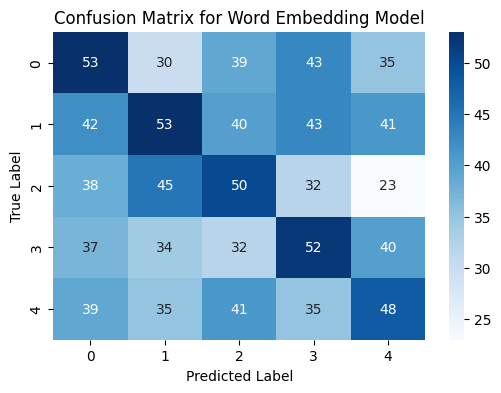

In [161]:
plt.figure(figsize=(6, 4))
sns.heatmap(metrics_word_embedding['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Word Embedding Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The confusion matrix for the word embedding model shows that the model makes mistakes fairly evenly across the different answer choices. The number of correct predictions (the diagonal values) is pretty consistent, ranging from 48 to 53 for each label. This means the model performs similarly across all answer options, without any one label being much easier or harder to predict.

Label 3 is the most accurate with 52 correct predictions, while label 2 is the lowest with 50. The model often confuses answers that are next to each other (like labels 0 and 1, or labels 3 and 4), which is shown by the higher number of mistakes between these pairs (e.g. 42 and 30 errors between 0 and 1 / 40 and 35 between 3 and 4). This likely happens because those answer choices are more similar to each other, and commonsense reasoning tasks can be tricky even for models.

### **RNN evaluation**

The function `evaluate_rnn_model()` evaluates the performance of an RNN-based model using a validation dataset. It does the following key things:

1. Processes batches of input data — including questions, choices, and their lengths — and sends them through the model to get predictions.
2. Compares model predictions with the true labels for each batch to see how well the model is performing.
3. Calculates key performance metrics such as accuracy, precision, recall, and F1 score to give a detailed view of the model’s effectiveness.
4. Generates a confusion matrix to visualize how often the model predicts each class correctly or incorrectly.

In [165]:
def evaluate_rnn_model(model, dataloader, device):
    model.eval()
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for batch in dataloader:

            padded_questions, question_lengths, padded_choices, choice_lengths, indices, labels = batch
            
            # Move to device
            padded_questions = padded_questions.to(device)
            question_lengths = question_lengths.to(device)
            padded_choices = padded_choices.to(device)
            choice_lengths = choice_lengths.to(device)
            indices = indices.to(device)
            labels = labels.to(device)
            
            # Forward pass with RNN-specific arguments
            outputs = model(padded_questions, question_lengths, padded_choices, choice_lengths, indices)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            # Collect labels and predictions
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())
    
    # Compute metrics
    from sklearn.metrics import (
        accuracy_score, 
        precision_score, 
        recall_score, 
        f1_score, 
        confusion_matrix
    )
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

I load the model from my folder for the evaluation with the `load_model()` function.

In [152]:
rnn_model = load_model(
    model_path=r'D:\\Dateien\\Github_FabianDubach\\NLP\\_Project\\checkpoints\\rnn-2025-04-07-19-34-34\\best_rnn_model.pt', 
    model_class=lambda: QARNNModel(
        embedding_dim=embedding_dim_rnn, 
        hidden_dim=hidden_dim_rnn, 
        dropout_rate=dropout_rate_rnn
    ),
    device=device
)

I use the `evaluate_rnn_model()` function to get the needed metrics.

In [153]:
metrics_rnn = evaluate_rnn_model(rnn_model, valid_rnn_loader, device)

C:\Users\fabia\AppData\Local\Temp\ipykernel_21744\665787113.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  question_tensors = [torch.tensor(q, dtype=torch.float32) for q in questions]
C:\Users\fabia\AppData\Local\Temp\ipykernel_21744\665787113.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  choice_tensors = [[torch.tensor(c, dtype=torch.float32) for c in cs] for cs in choices]


With the following for-loop, I print out the needed metrics.

In [154]:
for metric, value in metrics_rnn.items():
    if metric != 'confusion_matrix':
        print(f"{metric}: {value}")

accuracy: 0.233
precision: 0.23276919910636673
recall: 0.233
f1_score: 0.23222251093213703


To see what my RNN model actually predicted, I print out the confusion matrix.

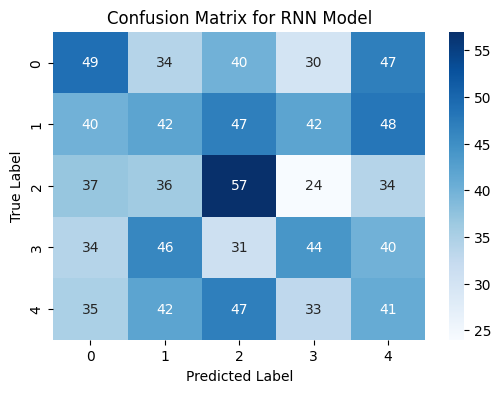

In [162]:
plt.figure(figsize=(6, 4))
sns.heatmap(metrics_rnn['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The RNN model's confusion matrix shows a similar spread of mistakes as the word embedding model, but with a few key differences. The most accurate label is 2, with 57 correct predictions, clearly higher than the others. Labels 0 and 1 are the hardest for the model, with fewer correct answers (49 and 42).

The RNN also makes more noticeable mistakes across very different answer choices. For example, it often mixes up labels 1 and 4 (48 times), and labels 0 and 4 (47 times). This could be because the RNN processes data in sequence, and sometimes that causes it to confuse answers that are far apart in meaning.

Overall, while the RNN shows signs of picking up deeper patterns in the data, it still has trouble with the tricky nature of commonsense reasoning, especially when answer choices are very different or too similar.

### **Model Performance Comparison**

Both the Word Embedding and RNN models demonstrate performance slightly above random chance (20% for a 5-choice classification task), indicating the challenging nature of the CommonsenseQA dataset.

The Word Embedding model shows a marginal performance advantage:

**Accuracy: 25.6%**<br>
**Precision: 25.65%**<br>
**Recall: 25.6%**<br>
**F1 Score: 25.59%**

The RNN model exhibits slightly lower performance:

**Accuracy: 23.3%**<br>
**Precision: 23.27%**<br>
**Recall: 23.3%**<br>
**F1 Score: 23.22%**

The similar accuracy, precision, recall and F1 scores for both models show that their overall performance is balanced. Looking at the confusion matrices, we can see that neither model is especially good at predicting one specific answer — their mistakes are spread out fairly evenly across all the answer choices.

The word embedding model seems just a bit better at understanding the meaning behind the questions and answers, but the difference is small. Both models have a hard time telling the answer choices apart, which shows how challenging commonsense reasoning really is.

Overall, these results highlight that this task is tough and we may need more advanced models or better context to see a big improvement in performance.

# **Interpretation**

The results from my models have been pretty disappointing and they raise more questions than answers. The accuracy is just barely above random guessing, which doesn’t necessarily mean complete failure, but it definitely suggests something isn’t quite right. First, I’m not fully confident in the implementation. I still think that something might be off, maybe in the data preprocessing, model architecture or training process. The small differences between the word embedding and RNN model make me think there could be subtle issues in how everything was set up.

What really caught my attention was learning that a research team using BERT only achieved around 56% accuracy on this same task. That makes it clear this commonsense reasoning problem is quite hard. I also suspect that the limited dataset is holding things back. With only around 9,000 training examples, the model probably isn’t seeing enough variety to truly learn the subtle patterns and context needed for commonsense reasoning. 

# **Tools/Resources used**

1. **Programming Environment**
   - Python 3.12.8
   - Jupyter Notebook

2. **Machine Learning and Deep Learning**
   - PyTorch (neural network development)
   - Hugging Face Datasets (data management)
   - NLTK (natural language preprocessing)
   - FastText (pre-trained word embeddings, 300-dimensional vectors)

3. **Data Manipulation and Analysis**
   - NumPy (numerical computing)
   - Pandas (data structuring and manipulation)
   - Scikit-learn (potential additional machine learning utilities)

4. **Visualization and Tracking**
   - Matplotlib (basic plotting)
   - Seaborn (statistical data visualization)
   - Weights & Biases (experiment tracking and logging)
     * Tracked metrics: training loss, accuracy, learning rates
     * Logged hyperparameter configurations
     * Enabled comparative analysis across model runs

5. **Computational Infrastructure**
   - CUDA-enabled GPU acceleration
   - GPU-optimized PyTorch operations
   - Efficient parallel computing for model training

6. **Dataset and Benchmarking**
   - CommonsenseQA dataset (Hugging Face)
   - Standard benchmark for commonsense reasoning tasks

7. **Additional Libraries**
   - Gensim (word vector processing)
   - tqdm (progress bar visualization)
   - datetime (experiment timestamping)

8. **AI-Tools**
   - Claude 3.5 Sonnet: Utilized as a coding assistant for debugging, optimization and documentation.
   - GPT-4-turbo: Assisted in drafting and refining documentation, helping with structure and phrasing.